In [5]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models4 import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (drop4): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=512, bias=True)
  (dropFC): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# test that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [11]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


C:\Users\rbaru\Anaconda3\envs\compVision\Notebooks\Facial Keypoint Detection\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [5]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 0)

In [6]:
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=data_transform)

In [7]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset,
                         batch_size = batch_size,
                         shuffle = True,
                         num_workers = 0)

In [8]:
# test the model on a batch of test images
def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

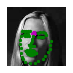

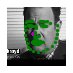

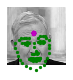

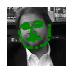

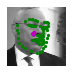

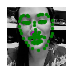

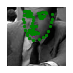

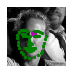

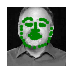

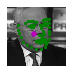

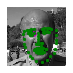

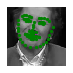

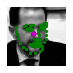

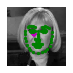

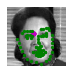

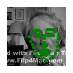

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=16):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [12]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [13]:
def train_net(n_epochs):
    
    # prepare the net for training
    net.train()
    
    for epoch in range(n_epochs): 
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # forward pass to get outputs
            output_pts = net(images)
            
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            # update the weights
            optimizer.step()
            
            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9: # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                
    print('Finished Training')

In [14]:
# train your network
n_epochs = 50 # start small and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 1.059124344587326
Epoch: 1, Batch: 20, Avg. Loss: 0.573033919930458
Epoch: 1, Batch: 30, Avg. Loss: 0.32628903687000277
Epoch: 1, Batch: 40, Avg. Loss: 0.2649598479270935
Epoch: 1, Batch: 50, Avg. Loss: 0.25321066826581956
Epoch: 1, Batch: 60, Avg. Loss: 0.24134185761213303
Epoch: 1, Batch: 70, Avg. Loss: 0.2472532108426094
Epoch: 1, Batch: 80, Avg. Loss: 0.2506803959608078
Epoch: 1, Batch: 90, Avg. Loss: 0.2335996985435486
Epoch: 1, Batch: 100, Avg. Loss: 0.22951906472444533
Epoch: 2, Batch: 10, Avg. Loss: 0.22841566652059556
Epoch: 2, Batch: 20, Avg. Loss: 0.2679820448160172
Epoch: 2, Batch: 30, Avg. Loss: 0.22924441397190093
Epoch: 2, Batch: 40, Avg. Loss: 0.2413745865225792
Epoch: 2, Batch: 50, Avg. Loss: 0.2233643040060997
Epoch: 2, Batch: 60, Avg. Loss: 0.24383081197738649
Epoch: 2, Batch: 70, Avg. Loss: 0.2953339800238609
Epoch: 2, Batch: 80, Avg. Loss: 0.2326218768954277
Epoch: 2, Batch: 90, Avg. Loss: 0.21172766238451005
Epoch: 2, Batch: 100, Av

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


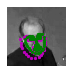

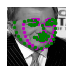

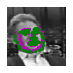

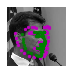

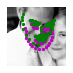

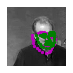

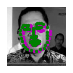

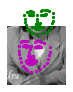

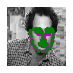

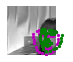

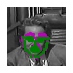

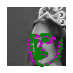

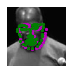

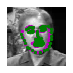

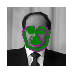

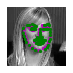

In [16]:
# visualize test output
visualize_output(test_images, test_outputs, gt_pts)

### Question 1: What optimization and loss functions did you choose and why?

For the loss function, I used the Mean Squared Error loss function.  I chose this function because the literature I read suggested MSE was the best and most common choice of loss function for regression problems.  Cross-entropy, the literature said, was best for binary classification problems.  I also experimented with the L1 loss function, but the results seemed best with the MSE function.

For the optimizer function, I chose the Adam function.  Originally, I used the Stochastic Gradient Descent function for optimization, but the error rate that resulted was too high.  Further, the literature I read suggested smaller data samples could be best optimized using an Adapative Learning Algorithim, such as Adagrad, Adadelta, RMSprop, or Adam.  After research, I concluded the Adam optimizer would best suit my needs because a) my sample size was relatively small, and b) the literature suggested Adam ran faster, which was of importance to me because of my computer's limited computation power.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

Originally, I experimented with 2 variations of the same model, which had only 2 convolutional layers.  In one model, I used batch normalization to compensate for overfitting.  In the other, I used a dropout function after each convolutional layer.  Though the results of the neural net testing were better with the dropout function than the batch normalization function, my model still delivered an unsatisfactorily high error rate.  

Finally, I added 3 more convolutional layers to reach a total of 5 convolutional layers in my neural network.  In concert with a dropout layer after each convolutional layer, an increased batch size, and an increased epoch value, my neural net finally achieved a satisfactorily low error rate of about 0.03.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

Originally, I worked with a batch size of 10.  I trained my first net with an epoch value of 10.  However, after encountering errors regarding the expected size of my output from my convolutional layers, I reduced my epoch value to 1 so that I could confirm that the hyperparameters of my neural network were correct and that the output/input matrix sizes were valid.  Once my neural net trained through 1 epoch correctly, I trained the final version of it with an epoch value of 50.

While I started with a batch size of 10, I later increased my batch size to 32 because I read in my research that a batch size that was a power of 2 was ideal.  32 seemed, to me, to be a reasonable number that was a) a power of 2, b) large enough to allow for efficient training, and c) small enough to be time manageable.  

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [3]:
import torch
from models4 import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/KeshNet_4.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (drop4): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=512, bias=True)
  (dropFC): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)

torch.Size([32, 1, 3, 3])
[[ 0.03303015  0.3040087   0.17803225]
 [-0.30441588 -0.24836585  0.18172958]
 [-0.30623612  0.20528576 -0.2707319 ]]
(3, 3)


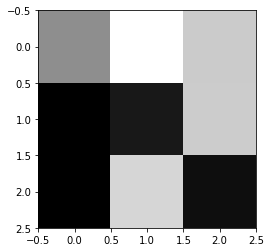

In [7]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()
print(weights1.shape)
filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

torch.Size([1, 224, 224])


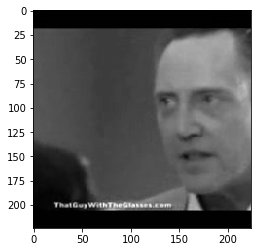

In [12]:
sample = transformed_dataset[9]
image = sample['image']
print(image.shape)
image = image.numpy().reshape(224, 224)
plt.imshow(image, cmap='gray')

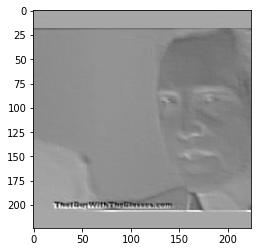

In [13]:
import cv2
b = w[0][0]
image_copy = image
image_copy = cv2.filter2D(image_copy, -1, b)
plt.imshow(image_copy, cmap='gray')

In [23]:
model_dir = 'saved_models/'
model_name = 'KeshNet_4.pt'

torch.save(net.state_dict(), model_dir+model_name)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The weight I selected for the tests below appears to locate edges between highlighted and shaded areas of the image with a bias toward the right side of the image, where the face appears. 

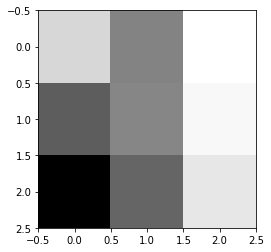

In [18]:
plt.imshow(w[5][0], cmap='gray')

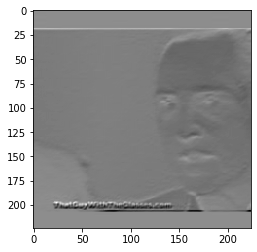

In [14]:
b = w[5][0]
image_copy = image
image_copy = cv2.filter2D(image_copy, -1, b)
plt.imshow(image_copy, cmap='gray')